# Small-Cap Stock Price-Movement Prediction and Price-Target Forecasting

#### Author: Jake Oddi

## Business Problem

Quantitative analysis of stocks has become increasingly popular over the past decades, to the point where it is ubiqiutous among insitutional investors. Among individual investors, however, it is less widespread. This is due to a general lack of the technical skills required to perform such analysis. I ran into this issue myself when constructing my portfolio. I predict an easy-to-use, open-source model would serve to benefit this population. 

This project applies classification methods to the daily price data of stocks with market capitalizations between \\$75M and \\$1B from the past three years to predict intraday price movements. Instances where the closing price exceeds the opening price are considered positive cases, and instances where the opposite is true are considered negative. The timescale for this data (daily) meant predicting the position of closing price relative to opening price was a desirable classification problem, as it is harder to do with time series modeling. Conversely, time series modeling to predict exact price is much better suited to interday prices, which is what I use it for. 

My analysis focuses on small-cap companies because they typically see lower trading volumes, and therefore have more inefficiencies that can be exploited and less noisey trading prices. Conversely, this makes trades harder to execute at desirable prices. 

Predictions of price-movement direction and price-target are nowhere near perfect, and should only be used in conjunction with additional information. In general, quantitative analysis should be combined with fundamental analysis.

To use the following project for one's own analysis, one must first create a TD Ameritrade Developer account, create an app, and fetch his or her API key, replacing mine in the form of the 'consumer_key' variable. Next, under the 'Selection' section, one should change the 'ticker_list' variable to include whichever tickers are to be included in his or her model. This will allow one to run the rest of the code and yield the same analysis as is already shown.

In [451]:
import pandas as pd
import numpy as np
np.random.seed(seed = 1)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import json
import time
from config import ameritrade_credentials
import price_forecasting_code.functions as fn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import itertools
import statsmodels.api as sm
import warnings
import tensorflow as tf
tf.random.set_seed(2)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import History
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Understanding

### Data Acquisition

To decide which companies to model, I employed a stock screener from [TD Ameritrade](https://research.tdameritrade.com/grid/public/screener/stocks/overview.asp) to select stocks with market caps within my desired range. This yielded 8027 results. I filtered this down to 3055 results by removing companies worth less than \\$75M, as many companies below that threshold had such low trading volumnes that they were not conducive to modeling. For the sake of ease-of-use and proof-of-concept, I filtered this down further by randomly sampling 500. I then gathered daily price data from the past three years using [TD Ameritrade's Price History API](https://developer.tdameritrade.com/price-history/apis). Of these 500, the API failed for 157, leaving 343. Of the remaining, I selected only those with 756 days of data to use in my analysis, leaving me with 160 stocks. 

In [3]:
# Read in the screener
screen = pd.read_csv('./data./ameritrade_stock_screener.csv', header = 0)

# Take a first look
screen.head()

,Symbol,Company Name,Market Capitalization,Sector,Industry,Dividend Yield,Beta
0,AAAIF,ALTERNATIVE INVESTMENT TRUST UNITS,2.856715e+07,NaN,NaN,--,+0.2
1,AACG,ATA Creativity Global(ADR),3.713346e+07,Consumer Discretionary,Diversified Consumer Services,--,+1.7
2,AACH,AAC Holdings Inc,4.025300e+05,Health Care,Health Care Providers & Services,--,+2.7
3,AACQ,Artius Acquisition Inc,9.341573e+08,NaN,NaN,--,--
4,AACS,"American Commerce Solutions, Inc.",6.946900e+05,Industrials,Road & Rail,--,-1.0


#### Screener Cleaning

In [4]:
# Rename screener columns
screen.columns = ['ticker', 'company', 'market_cap', 'sector', 'industry', 'dividend_yield', 'beta']

# Screening only for companies worth > $75M
screen = screen[screen['market_cap'] >= 75000000]

#### Selection

In [5]:
# Instantiate a list of 500 random integers for selection of df indices from the screener
rand_list = np.random.randint(0, screen.shape[0], 500)

# Filter the screener using the list of random indices
filtered_screen = screen.iloc[rand_list]

# Create a list of the tickers of all stocks selected by the filter
ticker_list = filtered_screen['ticker'].values

#### API Call - Configuration

In one's own analysis using Ameritrade's API, he or she must use their own API key in place of my 'consumer_key' variable.

In [6]:
# Import personal client ID
client_id = ameritrade_credentials.consumer_key

# Set payload params
period = '3'
period_type = 'year'
frequency = '1'
frequency_type = 'daily'
start_date = '1512172799'
end_date = '1606867199'

# Define payload
payload = {'apikey': client_id,
           'periodType': period_type,
           'frequencyType': frequency_type,
           'frequency': frequency,
           'period': period,
#            'endDate': end_date,
#            'startDate': start_date,
           'needExtendedHoursData': 'false'
          }

#### API Call

In [7]:
def get_data_from_ameritrade(ticker_list, payload):
    """
    Takes in list of tickers and payload and returns complete dataframe with all 
    tickers and prices.
    
    ticker_list -- array of strings containing n number of tickers
    payload -- dictionary containing parameters for API call
    """
    df_list = []
    fail_cache = []
    payload = payload
    for ticker in ticker_list:
        # Define endpoint
        endpoint = r'https://api.tdameritrade.com/v1/marketdata/{}/pricehistory'.format(ticker)
        
        try:
            # Make Request
            content = requests.get(url = endpoint, params = payload)

            # Convert to dataframe
            data = content.json()
            data = pd.DataFrame(data = data['candles'])
            data['ticker'] = ticker

            # Append to list of dataframes
            df_list.append(data)
            
        except:
            # Append problematic ticker to list of failed tickers
            fail_cache.append(ticker)
            continue
    
    return df_list, fail_cache

In [8]:
# A list of dfs is instantiated, where each stock's data is stored in a dataframe
df_list, fail_cache = get_data_from_ameritrade(ticker_list, payload)

In [9]:
print('Length of df_list:', len(df_list))
print('Length of fail_cache', len(fail_cache))

Length of df_list: 443
Length of fail_cache 57


#### Final Filtering

The last step in the filtering process cuts the number of stocks down to 160.

In [10]:
# Filtering only for stocks with greater than 755 days of price data
df_list = list(filter(lambda x: x.shape[0] >= 755, df_list))

In [11]:
len(df_list)

220

### Understanding

The API returned a dataframe with the following columns built in for each stock: opening price, daily high, daily low, closing price, datetime, volume, and ticker.

In [12]:
df_list[0].head()

,open,high,low,close,volume,datetime,ticker
0,19.50,19.65,19.225,19.40,156438,1515736800000,FRGI
1,19.55,19.60,18.950,19.10,216619,1516082400000,FRGI
2,19.10,19.40,19.100,19.30,238777,1516168800000,FRGI
3,19.30,19.35,18.950,19.20,133691,1516255200000,FRGI
4,19.25,19.75,19.250,19.65,213312,1516341600000,FRGI


## Cleaning

The first step is to check for NaN values in each of the dataframes. If a dataframe contains a NaN value, the below loop will return the ticker associated with that dataframe.

In [13]:
# Checking for NaN values in each dataframe
for df in df_list:
    if df.isna().sum().sum() != 0:
        print(df['ticker'][0])

Next I'll check the datatypes of each column of each dataframe.

In [14]:
df_list[0].dtypes

open        float64
high        float64
low         float64
close       float64
volume        int64
datetime      int64
ticker       object
dtype: object

The last thing to check is that each dataframe has the expected number of datapoints - 756.

In [15]:
for df in df_list:
    if df.shape[0] != 756:
        print(df['ticker'][0])

FRGI
EMF
TNP
AMEH
GLRE
BLE
WETF
SFE
WASH
AVXL
RUTH
SRRA
ZOM
CYBE
JRS
MUJ
FSP
PERI
FF
SLCT
NBEV
PMX
CURO
SXI
SECO
IDN
CEM
XBIT
UEC
CCRN
LC
HROW
EFT
ABUS
PLSE
IVAC
NC
HCI
LILA
FISI
MIN
GBLI
HCCI
ANIX
WLKP
CONN
TSC
HTD
SSSS
GMLP
MCS
GGN
MSD
CARA
MHLD
KBAL
LC
PFBI
PUMP
TNAV
FRPH
FMNB
CGBD
KNOP
EDD
MHN
PNF
AJX
VGM
NC
ANH
SALT
CCD
ANH
EFT
ECOM
PDFS
MUS
MUJ
PI
KTF
PZN
SGU
SXC
CMCM
ARAV
CDR
JPC
EMO
PERI
DMB
NMI
WEA
FDEU
PMBC
OCX
PPR
THQ
RNET
MTRX
CAL
EGAN
XOMA
AFMD
DUC
KNL
ESSA
SFUN
TAST
LCUT
FNKO
TOUR
FLDM
ATHX
GDP
MMT
NEON
SCYX
UEC
SALT
CTMX
CSWC
TCS
BGX
GLDD
CASI
LRN
MNKD
HOV
FNKO
CRVS
NMM
JRS
MIN
PEIX
BGX
IIF
PHT
GCO
SCOR
MTT
XONE
SMSI
MOV
CDR
CNBKA
NFBK
SCHN
NOG
XENE
BTO
CO
IRS
HLX
CGO
FENC
BSD
VNDA
AGFS
COWN
PRQR
GLP
BGB
UAN
FI
WLL
SIEN
KRNY
FBIZ
RM
LWAY
DHT
ATRS
WHF
IGI
ZOM
NEV
SLS
PML
MUC
THQ
ZIXI
FTK
LTRPA
WETF
UEPS
TELL
JPI
CVGI
DMLP
BANX
TRTX
EML
MITT
GDP
ESGC
IIF
CVCY
CSTR
TRTX
CEVA
EVI
TBI
ADMA
LDP
BFK
STBA
BNFT
IFRX
ANIK
EGRX
CPST
WRLD
VCV
GCI
VERU
MUJ
IGD
WETF
MUI


The data arrives quite clean. The only changes to be made are to the datetimes, which arrive in the unix format and need to be converted to a regular datetime, then set as the index. 

In [16]:
def clean_dates(df_list):
    """
    Takes in a list of dfs and cleans the dates for each df.
    
    df_list -- list of dataframes
    """
    for df in df_list:
        # Convert from unix to year month day format
        df['datetime'] = pd.to_datetime(df['datetime'], unit = 'ms')

        # Set datetime as index
        df.set_index(df['datetime'], inplace = True)

        # Drop original datetime column
        df.drop(columns = 'datetime', inplace = True)
        
    return df_list

In [17]:
df_list = clean_dates(df_list)

### A First Look

For the purpose of examining all the stocks in the dataset, I need concetanate them all into one dataframe.

In [18]:
# Concatenating all the dfs in df_list
df_joined = pd.concat(df_list)

# Examining Shape
df_joined.shape

(166100, 6)

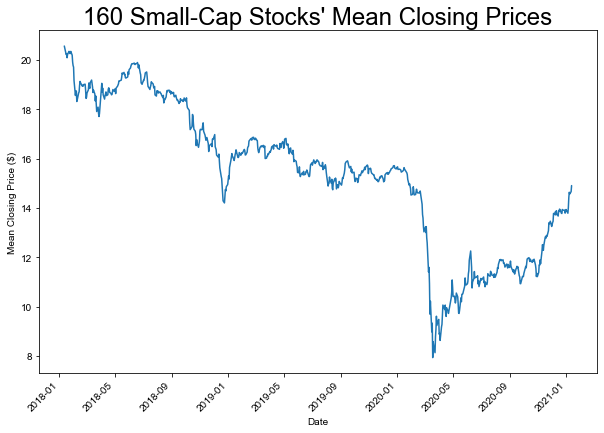

In [19]:
# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

# Assigning x and y variables so they can be graphed
x = date_close_gb.keys()
y = date_close_gb.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme(font_scale = 2)
sns.lineplot(x = x, y = y)
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices")
fig.autofmt_xdate(rotation=45)
plt.show()

As shown in the plot above, the average closing price of small cap stocks has been in a downward trend since year-end 2017, falling sharply around March 2020 due to the Coronavirus pandemic and its economic impact, failing to fully recover by December 2020. The trend is much more negative than the overall market, which rose consistently until March 2020, where it fell but proceeded to exceed pre-Covid levels by December 2020. 

## Feature Engineering

In [20]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

The first feature I engineered was my target variable. The target signifies whether a stock's closing price for one day exceeds its opening price. If this is the case, the target variable = 1. If the opposite is true, wherein the stock closes lower than it opened, the target variable = 0. If the closing and opening prices are exactly the same, the target variable = 2.

In [21]:
df_list = create_intra_clf_target(df_list)

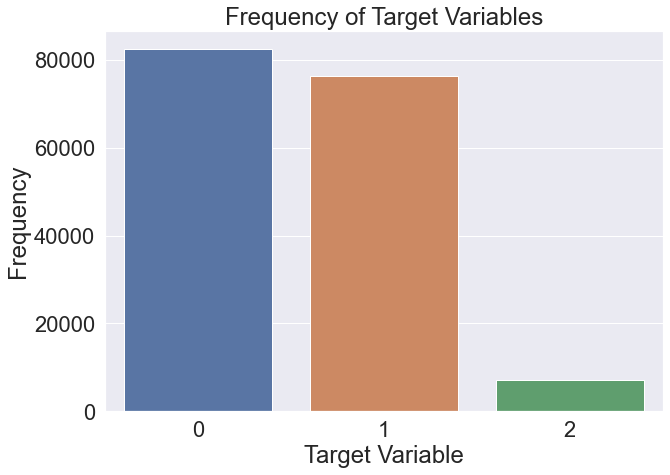

In [22]:
# Concatenating again after target variables have been created
df_joined_2 = pd.concat(df_list)

# Examining value counts of target variables
target_counts = df_joined_2['intra_clf_target'].value_counts()

# Assigning x and y variables for barplot
x = target_counts.keys()
y = target_counts.values

# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme(font_scale = 2)
sns.barplot(x = x, y = y)
ax.set(xlabel = 'Target Variable', 
       ylabel = 'Frequency', 
       title = "Frequency of Target Variables")
sns.barplot(x = x, y = y)
plt.show()

As shown in the barplot above, there are relatively equivalent amounts of positive and negative cases, but high imbalance when compared to the neither case. As a result, I will use F1-Score as my evaluation metric.

Unlike for classification, the target variable for my time series analysis does not need to be engineered. It is simply the closing price of each day I want to forecast into the future.

In [23]:
def create_moving_avs(df_list):
    """
    Takes in list of dfs, creates three different moving average 
    features - 10, 50, and 200 days.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['10_day_ma'] = df['close'].ewm(span = 10).mean()
        df['50_day_ma'] = df['close'].ewm(span = 50).mean()
        df['200_day_ma'] = df['close'].ewm(span = 200).mean()
     
    return df_list

I know that moving averages are important technical indicators for price movement, so the next features I created served to account for both long and short-term moving averages. I created features for a 10, 50, and 200 day moving average.

In [24]:
# Takes in list of dfs, creates three different moving average features - 10, 50, and 200 days.
df_list = create_moving_avs(df_list)

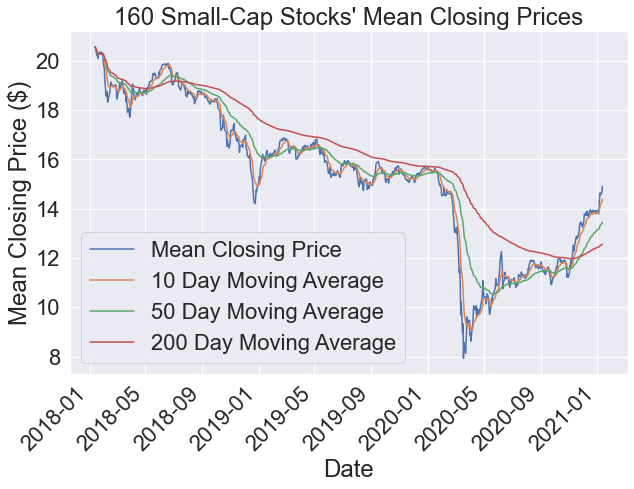

In [25]:
# Concatenating again after moving averages have been created
df_joined_3 = pd.concat(df_list)

# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()

ten_day_gb = df_joined_3.groupby(df_joined_3.index)['10_day_ma'].mean()
fifty_day_gb = df_joined_3.groupby(df_joined_3.index)['50_day_ma'].mean()
twohundred_day_gb = df_joined_3.groupby(df_joined_3.index)['200_day_ma'].mean()

# Assigning x1 and y1 to date and closing price
x1 = date_close_gb.keys()
y1 = date_close_gb.values

# Assigning x2 and y2 to the ten day moving average
x2 = ten_day_gb.keys()
y2 = ten_day_gb.values

# Assigning x3 and y3 to the fifty day moving average
x3 = fifty_day_gb.keys()
y3 = fifty_day_gb.values

# Assigning x4 and y4 to the two hundred day moving average
x4 = twohundred_day_gb.keys()
y4 = twohundred_day_gb.values


# Visualizing
fig, ax = plt.subplots(figsize = (10,7))
sns.set_theme(font_scale = 2)
sns.lineplot(x = x1, y = y1, label = 'Mean Closing Price')
sns.lineplot(x = x2, y = y2, label = '10 Day Moving Average')
sns.lineplot(x = x3, y = y3, label = '50 Day Moving Average')
sns.lineplot(x = x4, y = y4, label = '200 Day Moving Average')
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "160 Small-Cap Stocks' Mean Closing Prices")
fig.autofmt_xdate(rotation=45)
plt.show()

The various moving averages are shown in comparison to the mean closing prices for each day. As one would expect, the 200 day average is much less affected by small price movements, as opposed to the 10 day average, which follows the mean closing price very closely.

An important concept in quantitative finance is <b>Mean Reversion</b>, which holds that stocks tend to revert to the moving average of their prices.

In [26]:
def create_pct_price_changes(df_list):
    """
    Takes in a list of dfs and creates price change (%) features with various
    intervals.
    Calculates % price changes relative to the day before observed date to 
    prediction using unknown data.
    
    df_list -- list of dfs
    """
    # Creating i_day_pct_change columns in each df
    for df in df_list:
        df['1_day_pct_change'] = 0
        df['2_day_pct_change'] = 0
        df['3_day_pct_change'] = 0
        df['4_day_pct_change'] = 0
   
        # Calculating ith day price change for each col
        for i in range(5, df.shape[0]):
            # Difference in closing prices between the previous day and the previous day
            diff = float(df['close'][i-1]) - float(df['close'][i-2])
            pct = (float(diff)/float(df['close'][i-2])) * 100
            df['1_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and two days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-3])
            pct = (float(diff)/float(df['close'][i-3])) * 100
            df['2_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and three days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-4])
            pct = (float(diff)/float(df['close'][i-4])) * 100
            df['3_day_pct_change'][i] = pct
            
            # Difference in closing prices between the previous day and four days prior
            diff = float(df['close'][i-1]) - float(df['close'][i-5])
            pct = (float(diff)/float(df['close'][i-5])) * 100
            df['4_day_pct_change'][i] = pct
    
    return df_list

The following function creates price change (%) features with intervals ranging from one to four days for each df.
It calculates % price changes relative to the day before the observed date in order to avoid prediction using unknown data.

In [27]:
df_list = create_pct_price_changes(df_list)

In [28]:
def create_intra_clf_target(df_list):
    """
    Takes in list of dfs and creates target variable for each depending
    on if the closing price for each day exceeds the opening price. If the
    closing price exceeds the opening price, target = 1.
    
    df_list -- list of dfs
    """
    for df in df_list:
        df['intra_clf_target'] = 0
        for i in range(len(df)):
            
            if df['open'][i] < df['close'][i]:
                df['intra_clf_target'][i] = 1
            
            elif df['open'][i] > df['close'][i]:
                df['intra_clf_target'][i] = 0
    
            elif df['open'][i] == df['close'][i]:
                df['intra_clf_target'][i] = 2
    
    return df_list

In [29]:
df_list = create_intra_clf_target(df_list)

Below is an example of a dataframe with all features engineered:

In [30]:
df_list[0].head()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2018-01-12 06:00:00,19.50,19.65,19.225,19.40,156438,FRGI,0,19.400000,19.400000,19.400000,0,0,0,0
2018-01-16 06:00:00,19.55,19.60,18.950,19.10,216619,FRGI,0,19.235000,19.247000,19.249250,0,0,0,0
2018-01-17 06:00:00,19.10,19.40,19.100,19.30,238777,FRGI,1,19.261130,19.265378,19.266336,0,0,0,0
2018-01-18 06:00:00,19.30,19.35,18.950,19.20,133691,FRGI,0,19.240990,19.248040,19.249502,0,0,0,0
2018-01-19 06:00:00,19.25,19.75,19.250,19.65,213312,FRGI,1,19.358406,19.334989,19.331212,0,0,0,0


Note: The first five observed days contain no pct price change values. This is because there was no data before the first observed day, so all values begin on the fifth day. Below is a better representation:

In [31]:
df_list[0].tail()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2021-01-06 06:00:00,12.81,12.940,12.33,12.84,190982,FRGI,1,11.922597,11.495847,9.987015,17,10,11,8
2021-01-07 06:00:00,12.89,13.645,12.74,13.29,161100,FRGI,1,12.171216,11.566206,10.019898,2,19,12,14
2021-01-08 06:00:00,13.35,13.375,12.57,13.03,99550,FRGI,0,12.327358,11.623610,10.049866,3,5,24,16
2021-01-11 06:00:00,12.82,13.910,12.75,13.35,186935,FRGI,1,12.513293,11.691311,10.082720,-1,1,3,21
2021-01-12 06:00:00,13.14,14.420,13.14,14.12,146003,FRGI,1,12.805422,11.786554,10.122913,2,0,3,6


## Selecting a Sample

Due to time constraints, I wanted to select a subset of stocks on which to perform my analysis. I've chosen to use capital markets stocks, as their prices are affected the least by external influences. For example, biotechnology companies' prices are heavily influenced by their bringing new treatments and technologies to market. Capital markets companies performances are the most dependant on overall stock market performance out of all the industries in the dataset. 

In [32]:
# Selecting tickers from final df list
final_list = [x['ticker'][0] for x in df_list]

# Filtering screen df with 'industry' column for only those in the final screen
sample = screen[screen['ticker'].isin(final_list)]

# Getting tickers for the eight capital markets companies
cap_markets_tickers = list(sample[sample['industry'] == 'Capital Markets']['ticker'])

# Getting tickers for all other companies
other_tickers = list(sample[sample['industry'] != 'Capital Markets']['ticker'])

In [33]:
# Examining the eight capital markets firms
sample[sample['industry'] == 'Capital Markets']

,ticker,company,market_cap,sector,industry,dividend_yield,beta
750,BANX,StoneCastle Financial Corp,136071720.0,Financials,Capital Markets,7.45%,+0.8
1429,CGBD,TCG BDC Inc,625592990.0,Financials,Capital Markets,11.59%,+2.2
1725,COWN,Cowen Inc,662763700.0,Financials,Capital Markets,1.29%,+1.5
1853,CSWC,Capital Southwest Corporation,323109050.0,Financials,Capital Markets,9.49%,+1.2
5955,PZN,"Pzena Investment Management, Inc.",518829300.0,Financials,Capital Markets,1.69%,+1.5
6465,SFE,"Safeguard Scientifics, Inc",148131370.0,Financials,Capital Markets,--,+1.3
6831,SSSS,SuRo Capital Corp,250119840.0,Financials,Capital Markets,4.02%,+1.7
7759,WETF,Wisdom Tree Investments Inc,750605190.0,Financials,Capital Markets,2.38%,+1.7
7770,WHF,WhiteHorse Finance Inc,287644000.0,Financials,Capital Markets,10.19%,+1.6


In [34]:
# Instantiating list of capital markets stocks
cm_df_list = []

# Instantiating list of all other stocks
other_list = []

# If the company in the larger list of dfs is part of the cap markets list,
# append it to the list of cap markets companies
# If it's not on the cap markets list, append it to a list of other companies
for df in df_list:
    if df['ticker'][0] in cap_markets_tickers:
        cm_df_list.append(df)
    if df['ticker'][0] in other_tickers:
        other_list.append(df)

# Deleting two WETF duplicates
del(cm_df_list[0])
del(cm_df_list[-1])

In [35]:
len(cm_df_list)

9

Below is a barplot showing the distribution of the various sectors present in my final 160 stocks. Financials, which contain capital markets, dominate the group.

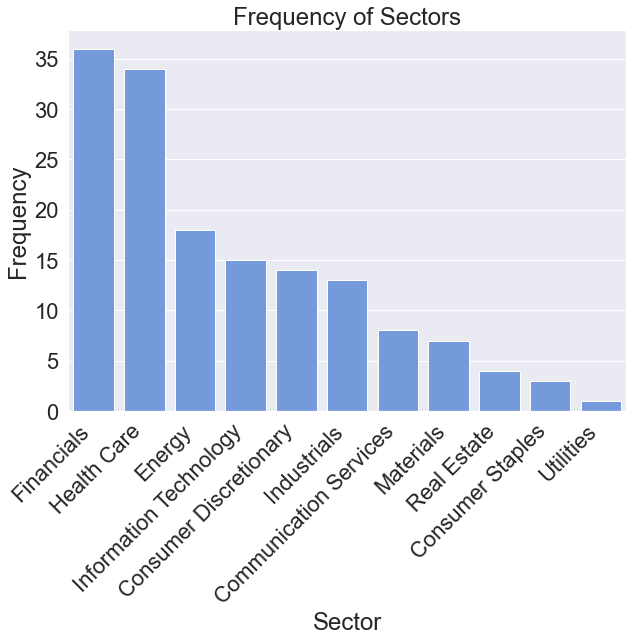

In [36]:
# Examining value counts for each sector
sector_counts = sample['sector'].value_counts()

# Assigning x and y variables for barplot
sector_x = sector_counts.keys()
sector_y = sector_counts.values

# Constructing plot
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(x = sector_x, y = sector_y)
ax.set(xlabel = 'Sector', 
       ylabel = 'Frequency', 
       title = "Frequency of Sectors")
ax.set_xticklabels(rotation = 45, ha = 'right', labels = sector_x)
sns.set_theme(font_scale = 1)
sns.barplot(x = sector_x, y = sector_y, color = 'cornflowerblue')
plt.show()

Next I wanted to test my hypothesis of capital markets stocks closely following the market. Below shows the mean daily closing prices of all 160 stocks, the eight capital markets stocks, and the 152 stocks that don't belong to the capital markets industry. Because the 160 is largely composed of the 152 other stocks, it's not surprising that the green line representing the other stocks so closely follows the overall trend that it obscures the blue line.

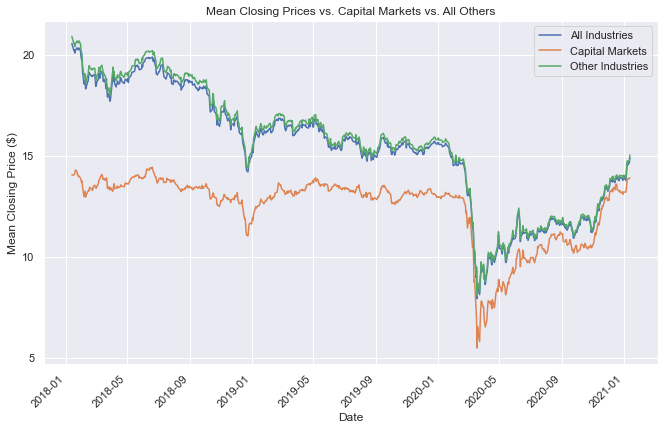

In [37]:
# Concatenating all the dfs in cm_df_list
cm_joined = pd.concat(cm_df_list)

# Concatenating all the dfs in other_list
others_joined = pd.concat(other_list)

# Grouping by date and mean closing price accross all stocks
date_close_gb = df_joined.groupby(df_joined.index)['close'].mean()
cm_close_gb = cm_joined.groupby(cm_joined.index)['close'].mean()
other_close_gb = others_joined.groupby(others_joined.index)['close'].mean()

# Assigning x and y variables so they can be graphed
x = date_close_gb.keys()
y = date_close_gb.values

# Cap Markets x and y
x1 = cm_close_gb.keys()
y1 = cm_close_gb.values

# All others x and y
x2 = other_close_gb.keys()
y2 = other_close_gb.values

# Visualizing
fig, ax = plt.subplots(figsize = (11,7))
sns.lineplot(x = x, y = y, label = 'All Industries')
sns.lineplot(x = x1, y = y1, label = 'Capital Markets')
sns.lineplot(x = x2, y = y2, label = 'Other Industries')
ax.set(xlabel = 'Date', 
       ylabel = 'Mean Closing Price ($)', 
       title = "Mean Closing Prices vs. Capital Markets vs. All Others"
      )
fig.autofmt_xdate(rotation=45)
sns.set_theme(font_scale = 3)
plt.show()

## Modeling and Results - Price Movement Classification

### Initial Model

My baseline model was a KNN and was used to evaluate my engineered features. 

In [38]:
# Assign a test dataframe on which to evaluate
df_test = df_list[0]

# Split into train and test sets on February 2, 2020
train = df_test[:'2020-02-02']
test = df_test['2020-02-02':]

X_train, y_train = train[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], train['intra_clf_target']

X_test, y_test = test[['10_day_ma', '50_day_ma', '200_day_ma', 
                          '1_day_pct_change',
                         '2_day_pct_change', 
                          '3_day_pct_change', 
                          '4_day_pct_change']], test['intra_clf_target']

# Instantiate the KNN Classifier
knn = KNeighborsClassifier()

# Instantiate the scaler
scaler = StandardScaler()

# Fit, transform on the train set, only transform on the test set
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test data
preds = knn.predict(X_test)

# Evaluate metrics
print('Acc:', accuracy_score(y_test, preds)) # price changes improved to .486 from .45
print('Precision:', precision_score(y_test, preds, average = 'weighted')) # improved from .44 with price change feature

Acc: 0.47280334728033474
Precision: 0.4668538074473266


My initial accuracy and precision scores were .451 and .448, respectively; however, the addition of my moving average and percent-price-change features saw these increase to .478 and .472, respectively.

In [168]:
def time_cross_validate(df, model, param_grid):
    """
    Takes in df, model, and param_grid, and returns cross validated scores and params.
    
    df -- dataframe
    model -- model to be used for cross validation
    param_grid -- dictionary to be used for GridSearch param_grid
    """
    # Designating predictor and target columns
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Creating dataframe with numerical index that can be split
    dataframe = df.reset_index()

    # Creating tuples of train, test indices to be passed into the cv parameter of GridSearchCV
    train_test_indices_1 = (list(range(455)), list(range(455, 530)))
    train_test_indices_2 = (list(range(530)), list(range(530, 605)))
    train_test_indices_3 = (list(range(605)), list(range(605, 680)))
    train_test_indices_4 = (list(range(680)), list(range(680, 755)))
    
    # Splitting the df into data and target values
    data, target = dataframe[predictor_cols], df[target]
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit_transform(data)
    
    # Instantiating Gridsearch
    
    # add pipeline into 'estimator'
    # Pipeline(StandardScaler, model)
    
    clf = GridSearchCV(estimator = model,
                       param_grid = param_grid,
                       cv = [train_test_indices_1,
                             train_test_indices_2,
                             train_test_indices_3,
                             train_test_indices_4
                       ],
                       n_jobs = -1,
                       scoring = 'f1_weighted',
                       verbose = False
    )
    
    # Fitting Gridsearch
    clf.fit(data, target)
    
    # Get results and store them in a dictionary
    best_score = clf.best_score_
    best_params = clf.best_params_
    best_params['best_score'] = best_score
    
    return best_params

### Gridsearch and Cross Validation

Next I wanted to add another model - Random Forest - then gridsearch my parameters and cross validate my evaluation metric, F1-Score. Because I have a high imbalance among my three classes, F1-Score serves to remedy much of the bias in scoring this may cause, as it takes into account precision and recall. I gridsearched only on the first ten dataframes in my list of dataframes for the sake of time. For each df and respective model fit to it, a dictionary with the parameters used in the model as well as the F1-Score attained with those parameters. For each model, I compile these into a list, then pick the parameters to use in my final models based on frequency.  

Because of the time series nature of the data, I had to create a custom means of cross validating my scoring metric. I split the data into five folds - one representing 60% of the data and four others, each representing 10%. Each of the subsets was in sequential order in relation to all others. I would train on the first, large set and test on the second set. Once I have my scoring metrics from that iteration, I would combine the original train and test sets into one training set then test on the next set in the order. I continued this process until I had tested on all four 'testing' sets, after which I averaged my metrics.

In [209]:
# Instantiate Random Forest and KNN Classifiers to be used in further modeling
rfc = RandomForestClassifier(random_state = 1)
knn = KNeighborsClassifier()

# Parameter grid for random forest gridsearch
rfc_param_grid = {'n_estimators': [500, 750, 1000],
                  'class_weight': ['balanced'],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [3, 5, 7]
             }

# Parameter grid for knn gridsearch
knn_param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                  'leaf_size': [15, 30, 40]
                 }

#### Random Forest

In [210]:
# Create a list of random forest best params and scores for first 10 dfs
rfc_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation 
    result = time_cross_validate(df = df, model = rfc, param_grid = rfc_param_grid)
    
    # Appending to list of dicts
    rfc_gs_results.append(result)            

In [211]:
rfc_gs_results

[{'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.5176355976288064},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 500,
  'best_score': 0.4121418774142814},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.4214129030051067},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 3,
  'n_estimators': 1000,
  'best_score': 0.41655311678972823},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 750,
  'best_score': 0.43670282997437815},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 3,
  'n_estimators': 500,
  'best_score': 0.5211071224115051},
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 7,
  'n_estimators': 1000,
  'best_score': 0.43345877098714847},
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_depth': 7,
 

In [212]:
# Calculating mean random forest F1 score for the first 10 stocks
np.mean([x['best_score'] for x in rfc_gs_results])

0.44703428885590774

The highest performing parameters for the Random Forest based on this gridsearch are:
* max_depth = 7
* n_estimators = 1000
* criterion = 'gini'
* class_weight = 'balanced'

#### KNN

In [213]:
# Create a list of knn best params and scores for first 10 dfs
knn_gs_results = []

for df in df_list[:10]:
    # Gridsearch and Cross Validation
    result = time_cross_validate(df = df, model = knn, param_grid = knn_param_grid)
    
    # Appending to list of dicts
    knn_gs_results.append(result)            

In [214]:
knn_gs_results

[{'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.576601109444148},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 7,
  'best_score': 0.49638011455886394},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.4731011104209102},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.48475326759503967},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.4389712818529228},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.49703569451333196},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 5,
  'best_score': 0.45593020019920844},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.4753586077256872},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 4,
  'best_score': 0.4893848500649194},
 {'algorithm': 'auto',
  'leaf_size': 15,
  'n_neighbors': 3,
  'best_score': 0.49386610662578456}]

In [215]:
# Calculating mean KNN F1 score for the first 10 stocks
np.mean([x['best_score'] for x in knn_gs_results])

0.4881382343000816

The highest performing parameters for the KNN based on this gridsearch are:
* algorithm = 'auto'
* leaf_size = 15
* n_neighbors = 3

In [216]:
def time_train_test_split(df, split_date):
    """
    Takes in a df and a date to split train and test sets
    on the split date and returns X_train, X_test, y_train, y_test.
    Built to be incorporated with time_cross_validate().
    
    df -- dataframe of prices
    split_date -- str formatted as 'YYYY-MM-DD'
    """
    # Create list of split components
    train_test_sets = [] # not being used
    
    # Create train and test sets
    train = df[:split_date]
    test = df[split_date:]
    
    # Create list of columns to use in prediction, as well as target variable
    predictor_cols = ['10_day_ma', 
                      '50_day_ma', 
                      '200_day_ma', 
                      '1_day_pct_change',
                      '2_day_pct_change', 
                      '3_day_pct_change', 
                      '4_day_pct_change']
    target = 'intra_clf_target'
    
    # Create train and test sets
    X_train, X_test = train[predictor_cols], test[predictor_cols]
    y_train, y_test = train[target], test[target]
    
    return X_train, X_test, y_train, y_test

In [217]:
def scale_and_plant_random_forests(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a Random Forest Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate Random Forest Classifier with gridsearched parameters
    rfc = RandomForestClassifier(random_state = 1,
                                 max_depth = 7,
                                 n_estimators = 1000,
                                 criterion = 'gini',
                                 class_weight = 'balanced'
                                )
    
    # Fit to the training data
    rfc.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rfc.predict(X_test)
    
    return (y_test, y_pred)

In [218]:
def scale_and_knn(X_train, X_test, y_train, y_test):
    """
    Takes in train and test sets, runs a K Nearest Neighbors Classifier on each,
    then returns a tuple of y test and y predicted values to be
    passed through an f1_score.
    
    X_train -- training prediction data
    X_test -- testing prediction data
    y_train -- training target data
    y_test -- testing target data
    """
    # Instantiate scaler
    scaler = StandardScaler()
    
    # Fit, transform on train set, only transform test set
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    # Instantiate K Neighbors Classifier with gridsearched parameters
    knn = KNeighborsClassifier(algorithm = 'auto',
                               leaf_size = 15, 
                               n_neighbors = 3
                              )
    
    # Fit to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = knn.predict(X_test)
    
    return (y_test, y_pred)

In [219]:
def compare_scores(df_list):
    """
    Takes in a list of dfs and returns a list of tuples to 
    compare the performance of two models based on their 
    respective F1 scores.
    
    df_list -- list of dfs
    """
    # Creating a list of tuples to compare model performance on each stock
    tuned_scores_comparison_list = []

    # Looping through the list of dfs
    for df in df_list:
        # Splitting train and test sets
        X_train, X_test, y_train, y_test = time_train_test_split(df, '2020-05-20')

        # Predicting with Random Forest
        (true, pred) = scale_and_plant_random_forests(X_train, X_test, y_train, y_test)

        # Evaluating Random Forest
        rfc_f1 = f1_score(true, pred, average = 'weighted')

        # Predicting with KNN
        (true, pred) = scale_and_knn(X_train, X_test, y_train, y_test)

        # Evaluating KNN
        knn_f1 = f1_score(true, pred, average = 'weighted')

        # Appending to list of tuples
        tuned_scores_comparison_list.append((rfc_f1, knn_f1))

    return tuned_scores_comparison_list

### Final Classification Models

#### Analysis of Results and Comparing Models

For my final Random Forest and KNN models, I used the parameters I obtained through my gridsearch. I anticipated that there would not be a clear favorite among the two models, and that instead KNN would perform better on some stocks while Random Forest would perform better on others. I evaluated both models on the first ten stocks, creating a list of tuples of F1-Scores. The first item in each tuple corresponds to the Random Forest F1 and the second to the KNN F1.

In [222]:
# Creating a list of tuples to compare model performance on each stock
comparison_list = compare_scores(cm_df_list)
comparison_list

[(0.4509692605926336, 0.4901152892169149),
 (0.30944654196808563, 0.4423287183594594),
 (0.38072286164810465, 0.5943245528288288),
 (0.3270178241615679, 0.5724220005461703),
 (0.5049749031359106, 0.4765149879448703),
 (0.3269822688930969, 0.39663309090060683),
 (0.44208826413480257, 0.45570681714302896),
 (0.46216861131465714, 0.5564158530435737),
 (0.4509692605926336, 0.4901152892169149),
 (0.4782157333112747, 0.5354857513708452)]

In [223]:
# Splitting the above tuples into individual lists of F1-Scores for the purpose of visualization
rfc_f1 = [x[0] for x in comparison_list]
knn_f1 = [x[1] for x in comparison_list]

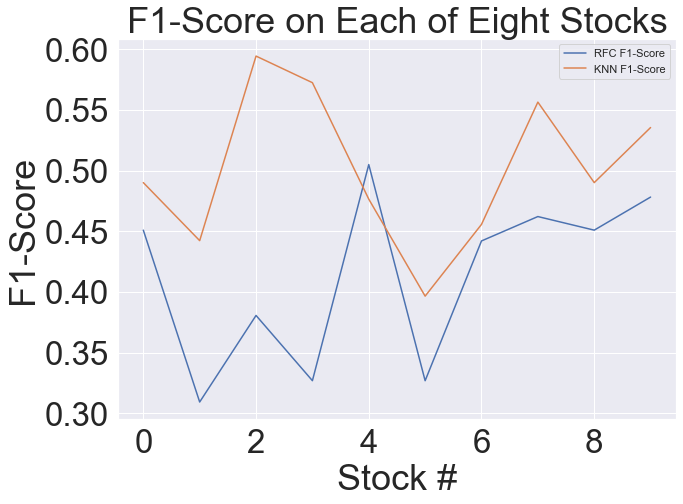

In [228]:
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(x = range(10), y = rfc_f1, label = 'RFC F1-Score')
sns.lineplot(x = range(10), y = knn_f1, label = 'KNN F1-Score')
ax.set(xlabel = 'Stock #',ylabel = 'F1-Score', title = 'F1-Score on Each of Eight Stocks')
sns.set_theme(font_scale = 1)
# ax.axhline(y = np.mean(rfc_f1), xmin = .05, xmax = .95)
# ax.axhline(y = np.mean(knn_f1), xmin = .05, xmax = .95, color = 'orange')
# ax.text(x = 9.5, y = np.mean(rfc_f1), s = str(round(np.mean(rfc_f1), 2)))
# ax.text(x = 9.5, y = np.mean(knn_f1), s = str(round(np.mean(knn_f1), 2)))
ax.legend()
plt.show()

Contrary to my initial assumption, the KNN F1-Score (.48) outperformed the RF F1-Score (.43) by .05 on average, as shown in the graph above.

# Time Series

In order to predict exact prices as opposed to price movements, I needed to use time series models like ARMA, which stands for Autoregressive Moving Average. The autoregressive portion of the title refers to the model's ability to predict a value based on values that came chronologically before it. The moving average portion is self explanatory, referring to the model's use of a moving average component in its forecasting.

## Data Inspection

I began by taking a look at a dataframe from my capital markets stock list to use as a test df to develop my first simple model.

In [53]:
cm_df_list[0].head()

,open,high,low,close,volume,ticker,intra_clf_target,10_day_ma,50_day_ma,200_day_ma,1_day_pct_change,2_day_pct_change,3_day_pct_change,4_day_pct_change
datetime,,,,,,,,,,,,,,
2018-01-12 06:00:00,10.00,10.2,10.000,10.15,64727,SFE,1,10.150000,10.150000,10.150000,0,0,0,0
2018-01-16 06:00:00,10.15,10.2,10.000,10.00,165225,SFE,0,10.067500,10.073500,10.074625,0,0,0,0
2018-01-17 06:00:00,10.00,10.1,9.825,9.85,117447,SFE,0,9.980066,9.996001,9.999000,0,0,0,0
2018-01-18 06:00:00,10.30,11.3,10.200,11.20,533626,SFE,1,10.381980,10.315296,10.303769,0,0,0,0
2018-01-19 06:00:00,11.15,11.7,11.050,11.45,214419,SFE,1,10.688580,10.560748,10.537623,0,0,0,0


In [57]:
df_test = cm_df_list[0]['close']

df_test.head()

datetime
2018-01-12 06:00:00    10.15
2018-01-16 06:00:00    10.00
2018-01-17 06:00:00     9.85
2018-01-18 06:00:00    11.20
2018-01-19 06:00:00    11.45
Name: close, dtype: float64

<AxesSubplot:xlabel='datetime'>

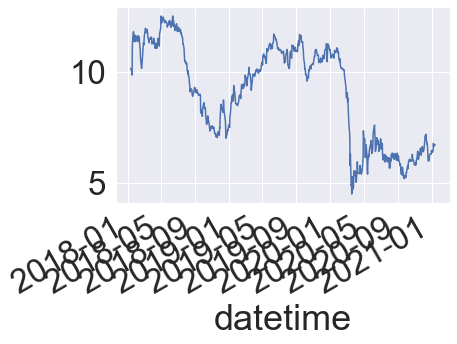

In [58]:
df_test.plot()

## ARMA

### Detrending

Next I move on to detrending in order to remove periodicity and acheive stationarity in my time series. I employ differencing to do this. ARMA models assume input data is stationary.

In [56]:
df_diff = df_test.diff(periods = 1)
df_diff.dropna(inplace = True)

<AxesSubplot:xlabel='datetime'>

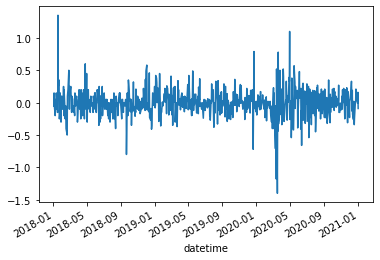

In [208]:
df_diff.plot()

In [197]:
# Dickey-Fuller test for stationarity
d_f = adfuller(df_diff)
d_f

(-17.832619508709396,
 3.1289329136918215e-30,
 1,
 753,
 {'1%': -3.4390641198617864,
  '5%': -2.8653859408474482,
  '10%': -2.5688179819544312},
 -237.80094601068822)

### Train/Test Split

In [54]:
end_train_date = '2020-12-01'
end_test_date = '2020-12-18'

In [58]:
# Slicing my data based on set dates
train = df_diff[:end_train_date]
test = df_diff[end_train_date:end_test_date]

### Modeling

Through trial and error I arrive at order parameters of 4 and 4 for AR and MA, respectively. These parameters dictate how many autoregressive and moving average terms exist within the ARMA function. They yielded me the lowest AIC score.

In [192]:
# Training the ARMA model on the training data
mod_arma = ARMA(train, order = (4,4)) # how to decide on order again?
res_arma = mod_arma.fit()
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                  734
Model:                     ARMA(4, 4)   Log Likelihood                 218.564
Method:                       css-mle   S.D. of innovations              0.180
Date:                Mon, 04 Jan 2021   AIC                           -417.129
Time:                        23:17:33   BIC                           -371.144
Sample:                             0   HQIC                          -399.392
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0148      0.008     -1.849      0.065      -0.031       0.001
ar.L1.close     1.0522   4.88e-05   2.16e+04      0.000       1.052       1.052
ar.L2.close    -0.6510      0.000  -4342.666      0.000      -0.651      -0.651
ar.L3.close     1.1767   2.45e-06    4.8e+05      0.000       1.177       1.177
ar.L4.close    -0.8154   8.58e-05  -9501.327      0.000      -0.816      -0.815
ma.L1.close    -1.0817      0.019    -58.208      0.000      -1.118      -1.045
ma.L2.close     0.6793      0.006    112.718      0.000       0.667       0.691
ma.L3.close    -1.1739      0.009   -124.085      0.000      -1.192      -1.155
ma.L4.close     0.8632      0.016     54.891      0.000       0.832       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3372           -0.9414j            1.0000           -0.3047
AR.2           -0.3372           +0.9414j            1.0000            0.3047
AR.3            1.0587           -0.3248j            1.1074           -0.0474
AR.4            1.0587           +0.3248j            1.1074            0.0474
MA.1           -0.3371           -0.9415j            1.0000           -0.3047
MA.2           -0.3371           +0.9415j            1.0000            0.3047
MA.3            1.0171           -0.3521j            1.0763           -0.0530
MA.4            1.0171           +0.3521j            1.0763            0.0530
-----------------------------------------------------------------------------
"""

In [213]:
# Forecasting with the trained model
preds = res_arma.forecast(steps = 14)

### Model Evalutation

Below is a lineplot comparing the true prices with the predicted ones. 

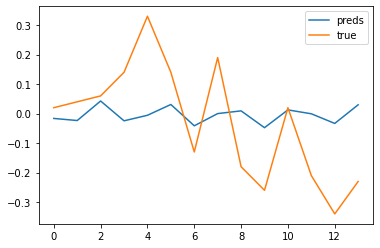

In [214]:
plt.plot(range(0,14), preds[0], label = 'preds')
plt.plot(range(0,14), test[:14], label = 'true')
plt.legend()

In [215]:
# Calculating RMSE of my forecasts
rmse = np.sqrt(mean_squared_error(test[0:14].values, preds[0]))
rmse

0.18662607399567527

A RMSE of .1866 means that the model's predictions differ from the actual differenced prices by $.1866 accross the 14 days; however, the model appears to be underfitting the data.

### Gridsearched ARMA

After building my first simple ARMA model, I wanted to gridsearch the p and q parameters to find the combination that would produce the lowest RMSE for each capital markets stock. For each stock, I predict fourteen days after the end of the training data. I mainly use RMSE as my scoring parameter, as I feel this best captures the dollar difference between actual and predicted prices.

In [59]:
# Defining AR and MA order components
p = range(0,5) # AR
q = range(0,5) # MA

In [60]:
# Creating every combination of p, d, and q parameters
pq = itertools.product(p, q)

# Converting from itertools product object to list
pq = list(pq)

In [195]:
def gridsearch_arma(orders_list, train, test, n_days = 14):
    """
    Takes in a list of orders, a train set, a test set, and a number of days
    to forecast into the future. Returns a list of results for each models and
    a list of any orders that caused the model to fail.
    
    orders_list -- A list of tuples containing p and q parameters
    train -- A series of the endogenous variable
    test -- A series of the endogenous variable to measure model performance
    n_days -- An integer denoting the number of days to forecast
    """
    # Instantiating a list of results dictionaries
    results_list = []

    # Instantiating fail cache
    fail_cache = []

    # Setting number of days to forecast forward
    n_days = n_days

    # Looping through each set of parameters to find the best combination
    for o in orders_list:
        try:
            # Instantiating new dictionary of results and parameters for each gridsearched model
            results_dict = {}

            # Instantiating the ARMA model
            arma = ARMA(train, 
                        order = o, 
                   )

            # Fitting the model
            fitted_arma = arma.fit()

            # Forecasting 14 days after training data
            arma_preds = fitted_arma.forecast(steps = n_days)[0]

            # Pulling AIC score from the model
            aic = fitted_arma.aic

            # Calculating RMSE for forecasted values
            rmse = np.sqrt(mean_squared_error(test[:n_days].values, arma_preds))

            # Assigning dictionary values of results and parameters
            results_dict['order'] = o
            results_dict['aic'] = aic
            results_dict['rmse'] = rmse

            # Adding each dictionary to the list of results dictionaries
            results_list.append(results_dict) 

        except:
            fail_cache.append({'order': o,
                               })
            continue
        
    return results_list, fail_cache

In [196]:
def get_best_time_series(results_list):
    """
    Takes in a list of results dictionaries containing SARIMA params
    and model performance metrics. Returns best model params and scores
    for RMSE and AIC, in that order.
    
    results_list -- list of results dictionaries.
    """    
    # Sorting scores list by RMSE
    sorted_by_rmse = sorted(results_list, key = lambda x: x['rmse'])
    
    # Top model by RMSE
    top_rmse_model = sorted_by_rmse[0]
    
    # Sorting scores list by AIC
    sorted_by_aic = sorted(results_list, key = lambda x: x['aic'])
    
    # Top model by AIC
    top_aic_model = sorted_by_aic[0]
    
    return [top_rmse_model, top_aic_model]

In [197]:
def gridsearch_arma_multiple(df_list, orders_list, n_days = 14):
    """
    Takes in a list of dfs, a list of order params, and a number 
    of days to forecast into the future. Returns gridsearched ARMA 
    model results for each.
    
    df_list -- list of dataframes
    orders_list -- A list of tuples containing p and q parameters
    n_days -- An integer denoting the number of days to forecast
    """
    # Creating list to hold results for each df
    best_model_list = []
    
    for df in df_list:
        # Isolate endogenous variable
        df_endog = df['close']
        
        # Create differenced df to improve stationarity
        df_diff = df_endog.diff(periods = 1)
        df_diff.dropna(inplace = True)
        
        # Split df into train and test sets
        train = df_diff[:end_train_date]
        test = df_diff[end_train_date:end_test_date]

        # Calculate all models(gridsearch)
        arma_results, arma_fails = gridsearch_arma(pq, train, test, n_days = n_days)

        # Identify best models based on RMSE and AIC, respectively
        best_arma = get_best_time_series(arma_results)
        
        # Pull ticker from df
        ticker = df['ticker'][0]
        
        # Append ticker and model results to list of best models
        best_model_list.append([ticker, best_arma])
        
    return best_model_list

In [198]:
# Calculate all models(gridsearch)
arma_results, arma_fails = gridsearch_arma(pq, train, test, n_days = 14)

# Identify best models based on RMSE and AIC, respectively
get_best_time_series(arma_results)

[{'order': (2, 4), 'aic': -429.6137454006571, 'rmse': 0.20615147490709979},
 {'order': (2, 4), 'aic': -429.6137454006571, 'rmse': 0.20615147490709979}]

In [200]:
# Compiling a list of the best performing order parameters for each stock
best_model_list = gridsearch_arma_multiple(cm_df_list, pq, n_days = 14)
best_model_list

[['WETF',
  [{'order': (2, 4), 'aic': -429.6137454006571, 'rmse': 0.20615147490709979},
   {'order': (2, 4), 'aic': -429.6137454006571, 'rmse': 0.20615147490709979}]],
 ['SFE',
  [{'order': (4, 4), 'aic': -194.94726322654515, 'rmse': 0.18662607399567527},
   {'order': (2, 2),
    'aic': -202.30116844303393,
    'rmse': 0.19244505841167853}]],
 ['SSSS',
  [{'order': (4, 1), 'aic': 151.76133064956684, 'rmse': 0.3384472393942903},
   {'order': (4, 2), 'aic': 142.66548732369165, 'rmse': 0.3728610213827238}]],
 ['CGBD',
  [{'order': (1, 1), 'aic': 92.83175222429281, 'rmse': 0.1429342322093544},
   {'order': (4, 4), 'aic': 76.64221583900394, 'rmse': 0.15423463037066978}]],
 ['PZN',
  [{'order': (4, 4), 'aic': 9.164889879140446, 'rmse': 0.24611062646306225},
   {'order': (1, 2), 'aic': 6.7277117384137455, 'rmse': 0.262969572276142}]],
 ['MCC',
  [{'order': (3, 3), 'aic': 2609.2359968399155, 'rmse': 0.834844790177134},
   {'order': (0, 0), 'aic': 2603.738359624309, 'rmse': 0.8669689308962872}]

In [207]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_model_list])
mean_RMSE

0.28709074046300215

## Conclusion and Next Steps

The highest performing classification model was the KNN, though this is only on a sample of 8 out of 160. I'd like to predict on the entire set of 160, add additional models, and add an ensemble voting classifier.

For the eight small cap stocks I employed an ARMA model on, the average RMSE accross the 14 days was .287.

To further improve the models I have, I'd like to add more features, such as momentum indicators like Moving Average Convergence/Divergence (MACD) and Relative Strength Index (RSI), as well as a volatility indicator like Standard Deviation or Beta. I'd also like to add a percent-change-in-volume feature.

## SARIMA

### SARIMA next because next step up is to remove trends but not add exog

In [59]:
# SARIMA train/test split
train = df_test[:end_train_date]
test = df_test[end_train_date:end_test_date]

In [60]:
# Instantiating SARIMA model
sarima = SARIMAX(train,
                order = (1, 1, 1),
                seasonal_order = (1, 1, 1, 4),
                enforce_stationarity = False,
                enforce_invertibility = False
               )

# Fitting SARIMA to the training data
fitted_sarima = sarima.fit()

# Forecasting 14 days after training data
sarima_preds = fitted_sarima.forecast(steps = 14)

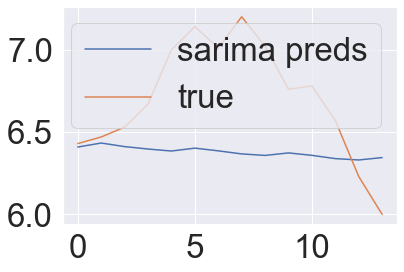

In [61]:
plt.plot(range(0,14), sarima_preds, label = 'sarima preds')
plt.plot(range(0,14), test[0:14], label = 'true')
plt.legend()

In [45]:
sarima_rmse = np.sqrt(mean_squared_error(test[0:14].values, sarima_preds))
sarima_rmse

0.5101237923678045

#### Gridsearched SARIMA

In [47]:
# Defining AR, I, MA, and S order components
p = range(0,2) # AR
d = range(0,2) # I
q = range(0,2) # MA
s = range(12, 13) # S 
# remember 4 for s
# try 3 for s

In [48]:
# Creating every combination of p, d, and q parameters
pdq = itertools.product(p, d, q)

# Converting from itertools product object to list
pdq = list(pdq)

In [49]:
# Creating every combination of seasonal(s) p, d, and q parameters
pdqs = itertools.product(p, d, q, s)

# Converting from itertools product object to list
pdqs = list(pdqs)

In [50]:
len(pdq)

8

In [51]:
len(pdqs)

8

In [52]:
num_iterations = len(pdq)*len(pdqs)
num_iterations

64

In [62]:
def gridsearch_sarima(orders_list, seasonal_orders_list, train, test, n_days = 14):
    """
    Takes in a list of orders, a train set, a test set, and a number of days
    to forecast into the future. Returns a list of results for each models and
    a list of any orders that caused the model to fail.
    
    orders_list -- A list of tuples containing p, d, and q parameters
    seasonal_orders_list -- A list of tuples containing p, d, q, and s parameters
    train -- A series of the endogenous variable
    test -- A series of the endogenous variable to measure model performance
    n_days -- An integer denoting the number of days to forecast
    """
    # Instantiating a list of results dictionaries
    results_list = []

    # Instantiating fail cache
    fail_cache = []

    # Setting number of days to forecast forward
    n_days = n_days

    # Looping through each set of parameters to find the best combination
    for o in orders_list:
        for so in seasonal_orders_list:
            try:
                # Instantiating new dictionary of results and parameters for each gridsearched model
                results_dict = {}

                # Instantiating the SARIMA model
                sarima = SARIMAX(train, 
                                 order = o, 
                                 seasonal_order = so, 
                                 enforce_stationarity = False,
                                 enforce_invertibility = False
                       )

                # Fitting the model
                fitted_sarima = sarima.fit()

                # Forecasting 14 days after training data
                sarima_preds = fitted_sarima.forecast(steps = n_days)

                # Pulling AIC score from the model
                aic = fitted_sarima.aic

                # Calculating RMSE for forecasted values
                rmse = np.sqrt(mean_squared_error(test[:n_days].values, sarima_preds))

                # Assigning dictionary values of results and parameters
                results_dict['order'] = o
                results_dict['seasonal_order'] = so
                results_dict['aic'] = aic
                results_dict['rmse'] = rmse

                # Adding each dictionary to the list of results dictionaries
                results_list.append(results_dict) 

            except:
                fail_cache.append({'order': o,
                                   'seasonal_order': so
                                   })
                continue
                
    return results_list, fail_cache

In [63]:
def get_best_time_series(results_list):
    """
    Takes in a list of results dictionaries containing SARIMA params
    and model performance metrics. Returns best model params and scores
    for RMSE and AIC, in that order.
    
    results_list -- list of results dictionaries.
    """    
    # Sorting scores list by RMSE
    sorted_by_rmse = sorted(results_list, key = lambda x: x['rmse'])
    
    # Top model by RMSE
    top_rmse_model = sorted_by_rmse[0]
    
    # Sorting scores list by AIC
    sorted_by_aic = sorted(results_list, key = lambda x: x['aic'])
    
    # Top model by AIC
    top_aic_model = sorted_by_aic[0]
    
    return [top_rmse_model, top_aic_model]

In [64]:
def gridsearch_sarima_multiple(df_list, orders_list, seasonal_orders_list, n_days = 14):
    """
    Takes in a list of dfs, a list of order params, and a number 
    of days to forecast into the future. Returns gridsearched ARMA 
    model results for each.
    
    df_list -- list of dataframes
    orders_list -- A list of tuples containing p and q parameters
    seasonal_orders_list -- A list of tuples containing p, d, q, and s parameters
    n_days -- An integer denoting the number of days to forecast
    """
    # Creating list to hold results for each df
    best_model_list = []
    
    for df in df_list:
        # Isolate endogenous variable
        df_endog = df['close']
        
        # Drop null values
        df_endog.dropna(inplace = True)
        
        # Split df into train and test sets
        train = df_endog[:end_train_date]
        test = df_endog[end_train_date:end_test_date]

        # Calculate all models(gridsearch)
        sarima_results, sarima_fails = gridsearch_sarima(pdq, pdqs, train, test, n_days = n_days)

        # Identify best models based on RMSE and AIC, respectively
        best_sarima = get_best_time_series(sarima_results)
        
        # Pull ticker from df
        ticker = df['ticker'][0]
        
        # Append ticker and model results to list of best models
        best_model_list.append([ticker, best_sarima])
        
    return best_model_list

In [65]:
# Calculate all models(gridsearch)
sarima_results, sarima_fails = gridsearch_sarima(pdq, pdqs, train, test, n_days = 14)

# Identify best models based on RMSE and AIC, respectively
get_best_time_series(sarima_results)

[{'order': (1, 1, 0),
  'seasonal_order': (0, 1, 0, 12),
  'aic': 290.724894097219,
  'rmse': 0.3645368052719063},
 {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 12),
  'aic': -220.7499581568162,
  'rmse': 0.4346656826904612}]

In [69]:
# Compiling a list of the best performing order parameters for each stock
best_sarima_list = gridsearch_sarima_multiple(cm_df_list, pdq, pdqs, n_days = 14)
best_sarima_list

[['SFE',
  [{'order': (1, 1, 0),
    'seasonal_order': (0, 1, 0, 12),
    'aic': 290.724894097219,
    'rmse': 0.3645368052719063},
   {'order': (0, 1, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -220.7499581568162,
    'rmse': 0.4346656826904612}]],
 ['SSSS',
  [{'order': (1, 0, 1),
    'seasonal_order': (1, 1, 0, 12),
    'aic': 448.51061356741405,
    'rmse': 0.3381566258082505},
   {'order': (0, 1, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': 140.57829415770016,
    'rmse': 0.5015262420138863}]],
 ['CGBD',
  [{'order': (1, 1, 0),
    'seasonal_order': (0, 1, 1, 12),
    'aic': 149.64451870665633,
    'rmse': 0.1691640614393601},
   {'order': (1, 1, 1),
    'seasonal_order': (0, 0, 0, 12),
    'aic': 98.46076984133464,
    'rmse': 0.2593146494587069}]],
 ['PZN',
  [{'order': (0, 1, 1),
    'seasonal_order': (1, 1, 0, 12),
    'aic': 228.83477546924377,
    'rmse': 0.34612079196640944},
   {'order': (1, 1, 1),
    'seasonal_order': (1, 0, 1, 12),
    'aic': -22.0802196

In [70]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_sarima_list])
mean_RMSE

0.3749437117125676

## SARIMAX

### Next step up is to add exogenous regressors

In [64]:
# Declaring columns to use as exogenous regressors
predictors = ['10_day_ma', '50_day_ma', '200_day_ma']

In [61]:
# Selecting a testing dataframe from the list of dfs
sarimax_df = df_list[0]

In [67]:
# Creating df of endogenous regressors
sarimax_endog = sarimax_df['close']

# Creating df of exogenous regressors
sarimax_exog = sarimax_df[predictors]

In [84]:
# Endogenous regressors train/test split
endog_train = sarimax_endog[:end_train_date]
endog_test = sarimax_endog[end_train_date:end_test_date]

In [85]:
endog_test

datetime
2020-12-01 06:00:00    12.29
2020-12-02 06:00:00    12.41
2020-12-03 06:00:00    13.16
2020-12-04 06:00:00    13.10
2020-12-07 06:00:00    12.91
2020-12-08 06:00:00    13.08
2020-12-09 06:00:00    13.04
2020-12-10 06:00:00    12.64
2020-12-11 06:00:00    12.42
2020-12-14 06:00:00    12.33
2020-12-15 06:00:00    12.62
2020-12-16 06:00:00    12.52
2020-12-17 06:00:00    12.07
2020-12-18 06:00:00    11.95
Name: close, dtype: float64

In [86]:
# Exogenous regressors train/test split
exog_train = sarimax_exog[:end_train_date]
exog_test = sarimax_exog[end_train_date:end_test_date]

In [87]:
exog_test

,10_day_ma,50_day_ma,200_day_ma
datetime,,,
2020-12-01 06:00:00,11.699897,10.507616,9.388734
2020-12-02 06:00:00,11.829007,10.582220,9.418815
2020-12-03 06:00:00,12.071006,10.683309,9.456064
2020-12-04 06:00:00,12.258095,10.778081,9.492345
2020-12-07 06:00:00,12.376624,10.861686,9.526373
2020-12-08 06:00:00,12.504510,10.948679,9.561754
2020-12-09 06:00:00,12.601872,11.030691,9.596384
2020-12-10 06:00:00,12.608804,11.093801,9.626687
2020-12-11 06:00:00,12.574476,11.145809,9.654498


### Test Model

In [88]:
# Instantiating SARIMA model
sarimax = SARIMAX(endog = endog_train,
                  exog = exog_train,
                  order = (1, 1, 1),
                  seasonal_order = (1, 1, 1, 12),
                  enforce_stationarity = False,
                  enforce_invertibility = False
               )

# Fitting SARIMAX to the training data
fitted_sarimax = sarimax.fit()

# Forecasting 14 days after training data
sarimax_preds = fitted_sarimax.forecast(steps = 14, exog = exog_test)

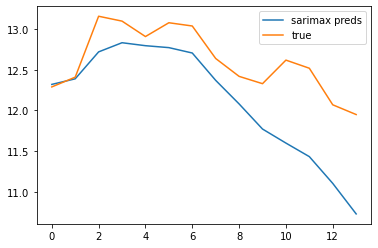

In [89]:
plt.plot(range(0,14), sarimax_preds, label = 'sarimax preds')
plt.plot(range(0,14), endog_test[:14], label = 'true')
plt.legend()

In [90]:
sarimax_rmse = np.sqrt(mean_squared_error(endog_test[:14].values, sarimax_preds))
sarimax_rmse

0.6346610300741182

### Gridsearched SARIMAX

In [77]:
# Defining AR, I, MA, and S order components
p = range(0,2) # AR
d = range(0,2) # I
q = range(0,2) # MA
s = range(12,13) # S
# remember 4 for s
# try 3 for s

In [78]:
# Creating every combination of p, d, and q parameters
pdq = itertools.product(p, d, q)

# Converting from itertools product object to list
pdq = list(pdq)

In [79]:
# Creating every combination of seasonal(s) p, d, and q parameters
pdqs = itertools.product(p, d, q, s)

# Converting from itertools product object to list
pdqs = list(pdqs)

In [80]:
len(pdq)

8

In [81]:
len(pdqs)

8

In [82]:
num_iterations = len(pdq)*len(pdqs)
num_iterations

64

In [85]:
def gridsearch_sarimax(orders_list, seasonal_orders_list, endog_train, 
                       exog_train, endog_test, exog_test, n_days = 14):
    """
    Takes in a list of orders, a train set, a test set, and a number of days
    to forecast into the future. Returns a list of results for each models and
    a list of any orders that caused the model to fail.
    
    orders_list -- A list of tuples containing p, d, and q parameters
    seasonal_orders_list -- A list of tuples containing p, d, q, and s parameters
    endog_train -- A series of the endogenous variable
    exog_train -- A dataframe with exogenous regressors 
    endog_test -- A series of the endogenous variable to measure model performance
    exog_test -- A dataframe of exogenous regressors for test set
    n_days -- An integer denoting the number of days to forecast
    """
    # Instantiating a list of results dictionaries
    results_list = []

    # Instantiating fail cache
    fail_cache = []

    # Setting number of days to forecast forward
    n_days = n_days

    # Looping through each set of parameters to find the best combination
    for o in pdq:
        for so in pdqs:
            try:
                # Instantiating new dictionary of results and parameters for each gridsearched model
                results_dict = {}

                # Instantiating the SARIMA model
                sarimax = SARIMAX(endog_train,
                                  exog_train,
                                  order = o, 
                                  seasonal_order = so, 
                                  enforce_stationarity = False,
                                  enforce_invertibility = False
                       )

                # Fitting the model
                fitted_sarimax = sarimax.fit()

                # Forecasting 14 days after training data
                sarimax_preds = fitted_sarimax.forecast(steps = n_days, exog = exog_test)

                # Pulling AIC score from the model
                aic = fitted_sarimax.aic

                # Calculating RMSE for forecasted values
                rmse = np.sqrt(mean_squared_error(endog_test[:14].values, sarimax_preds))

                # Assigning dictionary values of results and parameters
                results_dict['order'] = o
                results_dict['seasonal_order'] = so
                results_dict['aic'] = aic
                results_dict['rmse'] = rmse

                # Adding each dictionary to the list of results dictionaries
                results_list.append(results_dict) 

            except:
                fail_cache.append({'order': o,
                                   'seasonal_order': so
                                   })
                continue
                
    return results_list, fail_cache

In [86]:
def get_best_time_series(results_list):
    """
    Takes in a list of results dictionaries containing SARIMA params
    and model performance metrics. Returns best model params and scores
    for RMSE and AIC, in that order.
    
    results_list -- list of results dictionaries.
    """    
    # Sorting scores list by RMSE
    sorted_by_rmse = sorted(results_list, key = lambda x: x['rmse'])
    
    # Top model by RMSE
    top_rmse_model = sorted_by_rmse[0]
    
    # Sorting scores list by AIC
    sorted_by_aic = sorted(results_list, key = lambda x: x['aic'])
    
    # Top model by AIC
    top_aic_model = sorted_by_aic[0]
    
    return [top_rmse_model, top_aic_model]

In [87]:
def gridsearch_sarimax_multiple(df_list, orders_list, seasonal_orders_list, exog_vars, n_days = 14):
    """
    Takes in a list of dfs, a list of order params, and a number 
    of days to forecast into the future. Returns gridsearched ARMA 
    model results for each.
    
    df_list -- list of dataframes
    orders_list -- A list of tuples containing p and q parameters
    seasonal_orders_list -- A list of tuples containing p, d, q, and s parameters
    exog_vars -- A list of strings denoting which columns are to be used as exogenous regressors
    n_days -- An integer denoting the number of days to forecast
    """
    # Creating list to hold results for each df
    best_model_list = []
    
    for df in df_list:
        # Isolate endogenous variable
        df_endog = df['close']
        
        # Isolate exogenous variables
        df_exog = df[exog_vars]
        
        # Drop null values
        df_endog.dropna(inplace = True)
        df_exog.dropna(inplace = True)
        
        # Split endog df into train and test sets
        endog_train = df_endog[:end_train_date]
        endog_test = df_endog[end_train_date:end_test_date]
        
        # Split exog df into train and test sets
        exog_train = df_exog[:end_train_date]
        exog_test = df_exog[end_train_date:end_test_date]

        # Calculate all models(gridsearch)
        sarimax_results, sarimax_fails = gridsearch_sarimax(pdq, pdqs, endog_train, 
                                                            exog_train, endog_test, 
                                                            exog_test, n_days = n_days)

        # Identify best models based on RMSE and AIC, respectively
        best_sarimax = get_best_time_series(sarimax_results)
        
        # Pull ticker from df
        ticker = df['ticker'][0]
        
        # Append ticker and model results to list of best models
        best_model_list.append([ticker, best_sarimax])
        
    return best_model_list

In [89]:
best_sarimax_list = gridsearch_sarimax_multiple(cm_df_list, 
                                                pdq, 
                                                pdqs, 
                                                ['10_day_ma', '50_day_ma', '200_day_ma'])

In [91]:
best_sarimax_list

[['SFE',
  [{'order': (1, 1, 0),
    'seasonal_order': (1, 1, 1, 12),
    'aic': -493.4076663963718,
    'rmse': 0.14732361236186878},
   {'order': (0, 1, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -575.4499853705836,
    'rmse': 0.20830999165671635}]],
 ['SSSS',
  [{'order': (0, 1, 0),
    'seasonal_order': (1, 0, 0, 12),
    'aic': -212.1913475811396,
    'rmse': 0.22223281721847474},
   {'order': (1, 0, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -226.80036314982934,
    'rmse': 0.3142693048548323}]],
 ['CGBD',
  [{'order': (1, 0, 0),
    'seasonal_order': (0, 1, 1, 12),
    'aic': -217.8324068783457,
    'rmse': 0.14670158185457952},
   {'order': (1, 1, 0),
    'seasonal_order': (0, 0, 0, 12),
    'aic': -270.4178492865324,
    'rmse': 0.3290988128735025}]],
 ['PZN',
  [{'order': (1, 0, 1),
    'seasonal_order': (0, 0, 1, 12),
    'aic': -365.4312814100607,
    'rmse': 0.15367864913094526},
   {'order': (1, 1, 0),
    'seasonal_order': (1, 0, 1, 12),
    'aic': -37

In [90]:
# Calculating mean RMSE accross all eight stocks
mean_RMSE = np.mean([i[1][0]['rmse'] for i in best_sarimax_list])
mean_RMSE

0.20967791988540194

## LSTM RNN

train on training data, then predict on second to last and last train sets. evaluate bias/variance to iterate on architecture

### Test Models

In [94]:
# Instantiate a dataframe for testing
df_test = cm_df_list[0]

# Remove exogenous regressors
df_test = df_test['close']

# Endogenous regressors train/test split
rnn_train = df_test[:end_train_date]
rnn_test = df_test[end_train_date:end_test_date]

In [98]:
rnn_train.shape

(727,)

In [99]:
rnn_test.shape

(14,)

Below function taken from [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [415]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [416]:
# Setting raw input sequence
raw_seq = rnn_train.values

# Setting number of input and output/forecast steps
# 'From the past 365 trading days, predict the next 14'
n_steps_in, n_steps_out = 100, 14

# Splitting the sequence
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# Number of features is one because time series is univariate
n_features = 1

# Reshape from (samples, timesteps) into (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

In [417]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

In [418]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False)

In [419]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [420]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [421]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [422]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 1.170932733893342 Test: 1.3470970955846713


In [ ]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

## Hyperparameter and Architecture Tuning

### Tanh Activation

I want to test if a tanh activation will outperform a ReLu. In order to do this, I need to normalize my input data, as tanh functions can suffer from vanishing and exploding gradients.

In [423]:
# Setting raw input sequence
raw_seq = rnn_train.values

# Reshaping raw_seq from one dimensional to two dimensional vector for scaling
raw_seq = raw_seq.reshape(raw_seq.shape[0], 1)

# Fitting a normalizing scaler
scaler = MinMaxScaler()
scaler.fit(raw_seq)

# Setting number of input and output/forecast steps
# 'From the past n_steps_in trading days, predict the next n_steps_out'
n_steps_in, n_steps_out = 100, 14

# Splitting the sequence
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# Number of features is one because time series is univariate
n_features = 1

# Reshape from (samples, timesteps) into (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

# Scaling X with normalization
for i in range(X.shape[0]):
        X[i] = scaler.transform(X[i])

In [424]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, activation = 'tanh', input_shape = (n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

In [425]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False)

In [426]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape X_train from 1D to 2D vector
X_train = X_train.reshape(X_train.shape[0], 1)

# Scale train set
X_train = scaler.transform(X_train)

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape X_train from 1D to 2D vector
X_test = X_test.reshape(X_test.shape[0], 1)

# Scale test set
X_test = scaler.transform(X_test)

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [427]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [428]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [429]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.24992766784676643 Test: 0.5850721819755161


In [ ]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

There seems to be little difference in model performance between the two activation functions. Going forward, I will use the ReLu as it does not require scaling.

### Dropout Regularization

So far, the model seems to be overfitting to the training data, as its training performance is better than its testing performance. I'll add dropout regularization to attempt to increase the bias.

In [442]:
# Setting raw input sequence
raw_seq = rnn_train.values

# Setting number of input and output/forecast steps
# 'From the past 365 trading days, predict the next 14'
n_steps_in, n_steps_out = 100, 14

# Splitting the sequence
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# Number of features is one because time series is univariate
n_features = 1

# Reshape from (samples, timesteps) into (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], n_features)

In [443]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_steps_in, n_features)))
model.add(Dropout(.05))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [444]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False, callbacks = history)

In [445]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [446]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [447]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [448]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.36716290525429346 Test: 0.4275929238307735


In [ ]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

Dropout regularization seems to slightly improve model performance but could just be due to increasing the number of hidden units in the first LSTM layer from 50 to 100. Hard to tell because of inconsistent results.

Can I improve performance by adding another lstm layer, try bidirectional, then trying GRU layers, also training for longer

### Bidirectional LSTM

In [457]:
# Define model architecture
model = Sequential()
model.add(Bidirectional(LSTM(100, activation = 'relu', input_shape = (n_steps_in, n_features))))
model.add(Dropout(.05))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [458]:
# Fit the model
model.fit(X, y, epochs = 200, verbose = False, shuffle = False, callbacks = history)

In [459]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [460]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [461]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [462]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.6495342465413199 Test: 0.8812393474585622


In [ ]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
plt.plot(loss)

### Multiple LSTM, Dense Layers with Dropout

In [537]:
# Define model architecture
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape = (n_steps_in, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dropout(.05))
model.add(Dense(25))
model.add(Dropout(.1))
model.add(Dense(n_steps_out))
model.compile(optimizer = 'adam', loss = 'mse')

# Instantiate History object to plot loss
history = History()

In [544]:
# Fit the model
model.fit(X, y, epochs = 250, verbose = False, shuffle = False, callbacks = history)

In [545]:
# Set train evaluation input and outputs
X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
y_train = rnn_train.values[-n_steps_out:]

# Reshape input
X_train = X_train.reshape(1, n_steps_in, n_features)

# Set test evaluation input and outputs
X_test = rnn_train.values[-n_steps_in:]
y_test = rnn_test.values

# Reshape input 
X_test = X_test.reshape(1, n_steps_in, n_features)

In [546]:
# Predicting on train and test sets
y_pred_train = model.predict(X_train, verbose = False)[0]
y_pred_test = model.predict(X_test, verbose = False)[0]
# [0] is to access nested array

In [547]:
# Calculate RMSE for train and test predictions
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [548]:
print('Train:', train_rmse, 'Test:', test_rmse)

Train: 0.6087432285771494 Test: 0.6748498564555134


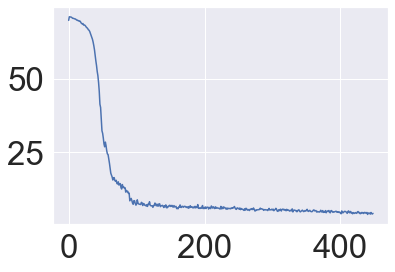

In [551]:
# Define loss variable for plotting
loss = history.history['loss']

# Plot loss
del(loss[1])
plt.plot(loss)

## Training Accross All Stocks

In [561]:
def rnn_multiple(df_list, n_steps_in, n_steps_out, end_train_date, end_test_date):
    """
    Takes in a list of dataframes, number of input and output steps, 
    and dates to end train and test sets.
    
    df_list -- list of dataframes
    n_steps_in -- integer
    n_steps_out -- integer
    end_train_date -- string in 'YYYY-MM-DD' format where the date field is optional
    end_test_date -- string in 'YYYY-MM-DD' format where the date field is optional
    """
    # Create list of results to store scores and fail cache to store failed dfs
    results_list = []
    fail_cache = []
    
    for df in df_list:
        try:
            # Define a dictionary to store model performance on each stock
            result = {}

            # Get ticker and add to result dictionary
            result['ticker'] = df['ticker'][0]

            # Remove exogenous regressors
            df = df['close']

            # Endogenous regressors train/test split
            rnn_train = df[:end_train_date]
            rnn_test = df[end_train_date:end_test_date]

            # Setting raw input sequence
            raw_seq = rnn_train.values

            # Setting number of input and output/forecast steps
            # 'From the past n_steps_in trading days, predict the next n_steps_out'
            n_steps_in, n_steps_out = n_steps_in, n_steps_out

            # Splitting the sequence
            X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

            # Number of features is one because time series is univariate
            n_features = 1

            # Reshape from (samples, timesteps) into (samples, timesteps, features)
            X = X.reshape(X.shape[0], X.shape[1], n_features)

            # Define model architecture
            model = Sequential()
            model.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape = (n_steps_in, n_features)))
            model.add(LSTM(50, activation = 'relu'))
            model.add(Dropout(.05))
            model.add(Dense(25))
            model.add(Dropout(.1))
            model.add(Dense(n_steps_out))
            model.compile(optimizer = 'adam', loss = 'mse')

            # Instantiate History object to plot loss
            history = History()

            # Fit the model
            model.fit(X, y, epochs = 250, verbose = False, shuffle = False, callbacks = history)

            # Set train evaluation input and outputs
            X_train = rnn_train.values[-(n_steps_in+n_steps_out):-n_steps_out]
            y_train = rnn_train.values[-n_steps_out:]

            # Reshape input
            X_train = X_train.reshape(1, n_steps_in, n_features)

            # Set test evaluation input and outputs
            X_test = rnn_train.values[-n_steps_in:]
            y_test = rnn_test.values

            # Reshape input 
            X_test = X_test.reshape(1, n_steps_in, n_features)

            # Predicting on train and test sets
            y_pred_train = model.predict(X_train, verbose = False)[0]
            y_pred_test = model.predict(X_test, verbose = False)[0]
            # [0] is to access nested array

            # Calculate RMSE for train and test predictions
            result['train_rmse'] = np.sqrt(mean_squared_error(y_train, y_pred_train))
            result['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))

            # Define loss variable for plotting
            result['loss'] = history.history['loss']

            # Append result dictionary to results_list
            results_list.append(result)
            
        except:
            fail_cache.append(df['ticker'][0])
            continue
            
    return results_list, fail_cache   

In [562]:
rnn_list, rnn_failed = rnn_multiple(cm_df_list, 
                                    n_steps_in = 100, 
                                    n_steps_out = 14, 
                                    end_train_date = end_train_date, 
                                    end_test_date = end_test_date)

KeyError: 'ticker'

In [563]:
rnn_list

NameError: name 'rnn_list' is not defined